# Import Libraries

In [1]:
!pip install feature_engine

     |████████████████████████████████| 205 kB 922 kB/s            


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.imputation import AddMissingIndicator
from feature_engine.encoding import MeanEncoder, RareLabelEncoder
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
import shap
random_state = 123

## looking at the big picture it seems a multiple univariate regression _ supervised learning 

# Get the data

In [3]:
train_set = pd.read_parquet('../input/kaggle-pog-series-s01e01/train.parquet')
test_set = pd.read_parquet('../input/kaggle-pog-series-s01e01/test.parquet')
submission = pd.read_csv('../input/kaggle-pog-series-s01e01/sample_submission.csv')

# Discover & visualize the Data to gain insights

In [4]:
train_set.shape, test_set.shape, submission.shape

((92275, 20), (5800, 16), (5, 2))

In [5]:
train_set.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,id,duration_seconds,has_thumbnail,target
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,3C66w5Z0ixs_2020-08-12,NaN,True,0.103596
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",M9Pmf9AB4Mo_2020-08-12,NaN,True,0.061611
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,J78aPJ3VyNs_2020-08-12,NaN,True,0.173523
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,kXLn3HkpjaA_2020-08-12,NaN,True,0.046804
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,VIUo6yapDbc_2020-08-12,NaN,True,0.040753


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92275 entries, 0 to 92274
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           92275 non-null  object             
 1   title              92275 non-null  object             
 2   publishedAt        92275 non-null  datetime64[ns, UTC]
 3   channelId          92275 non-null  object             
 4   channelTitle       92275 non-null  object             
 5   categoryId         92275 non-null  int64              
 6   trending_date      92275 non-null  object             
 7   tags               92275 non-null  object             
 8   view_count         92275 non-null  int64              
 9   likes              92275 non-null  int64              
 10  dislikes           92275 non-null  int64              
 11  comment_count      92275 non-null  int64              
 12  thumbnail_link     92275 non-null  object     

In [7]:
#I notice that "description, duration_seconds" had missing values ..let's take care of this
train_set["description"].fillna('None', inplace=True)

In [8]:
train_set["duration_seconds"].fillna('median', inplace=True)

In [9]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92275 entries, 0 to 92274
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           92275 non-null  object             
 1   title              92275 non-null  object             
 2   publishedAt        92275 non-null  datetime64[ns, UTC]
 3   channelId          92275 non-null  object             
 4   channelTitle       92275 non-null  object             
 5   categoryId         92275 non-null  int64              
 6   trending_date      92275 non-null  object             
 7   tags               92275 non-null  object             
 8   view_count         92275 non-null  int64              
 9   likes              92275 non-null  int64              
 10  dislikes           92275 non-null  int64              
 11  comment_count      92275 non-null  int64              
 12  thumbnail_link     92275 non-null  object     

array([[<AxesSubplot:title={'center':'publishedAt'}>,
        <AxesSubplot:title={'center':'categoryId'}>,
        <AxesSubplot:title={'center':'view_count'}>],
       [<AxesSubplot:title={'center':'likes'}>,
        <AxesSubplot:title={'center':'dislikes'}>,
        <AxesSubplot:title={'center':'comment_count'}>],
       [<AxesSubplot:title={'center':'target'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

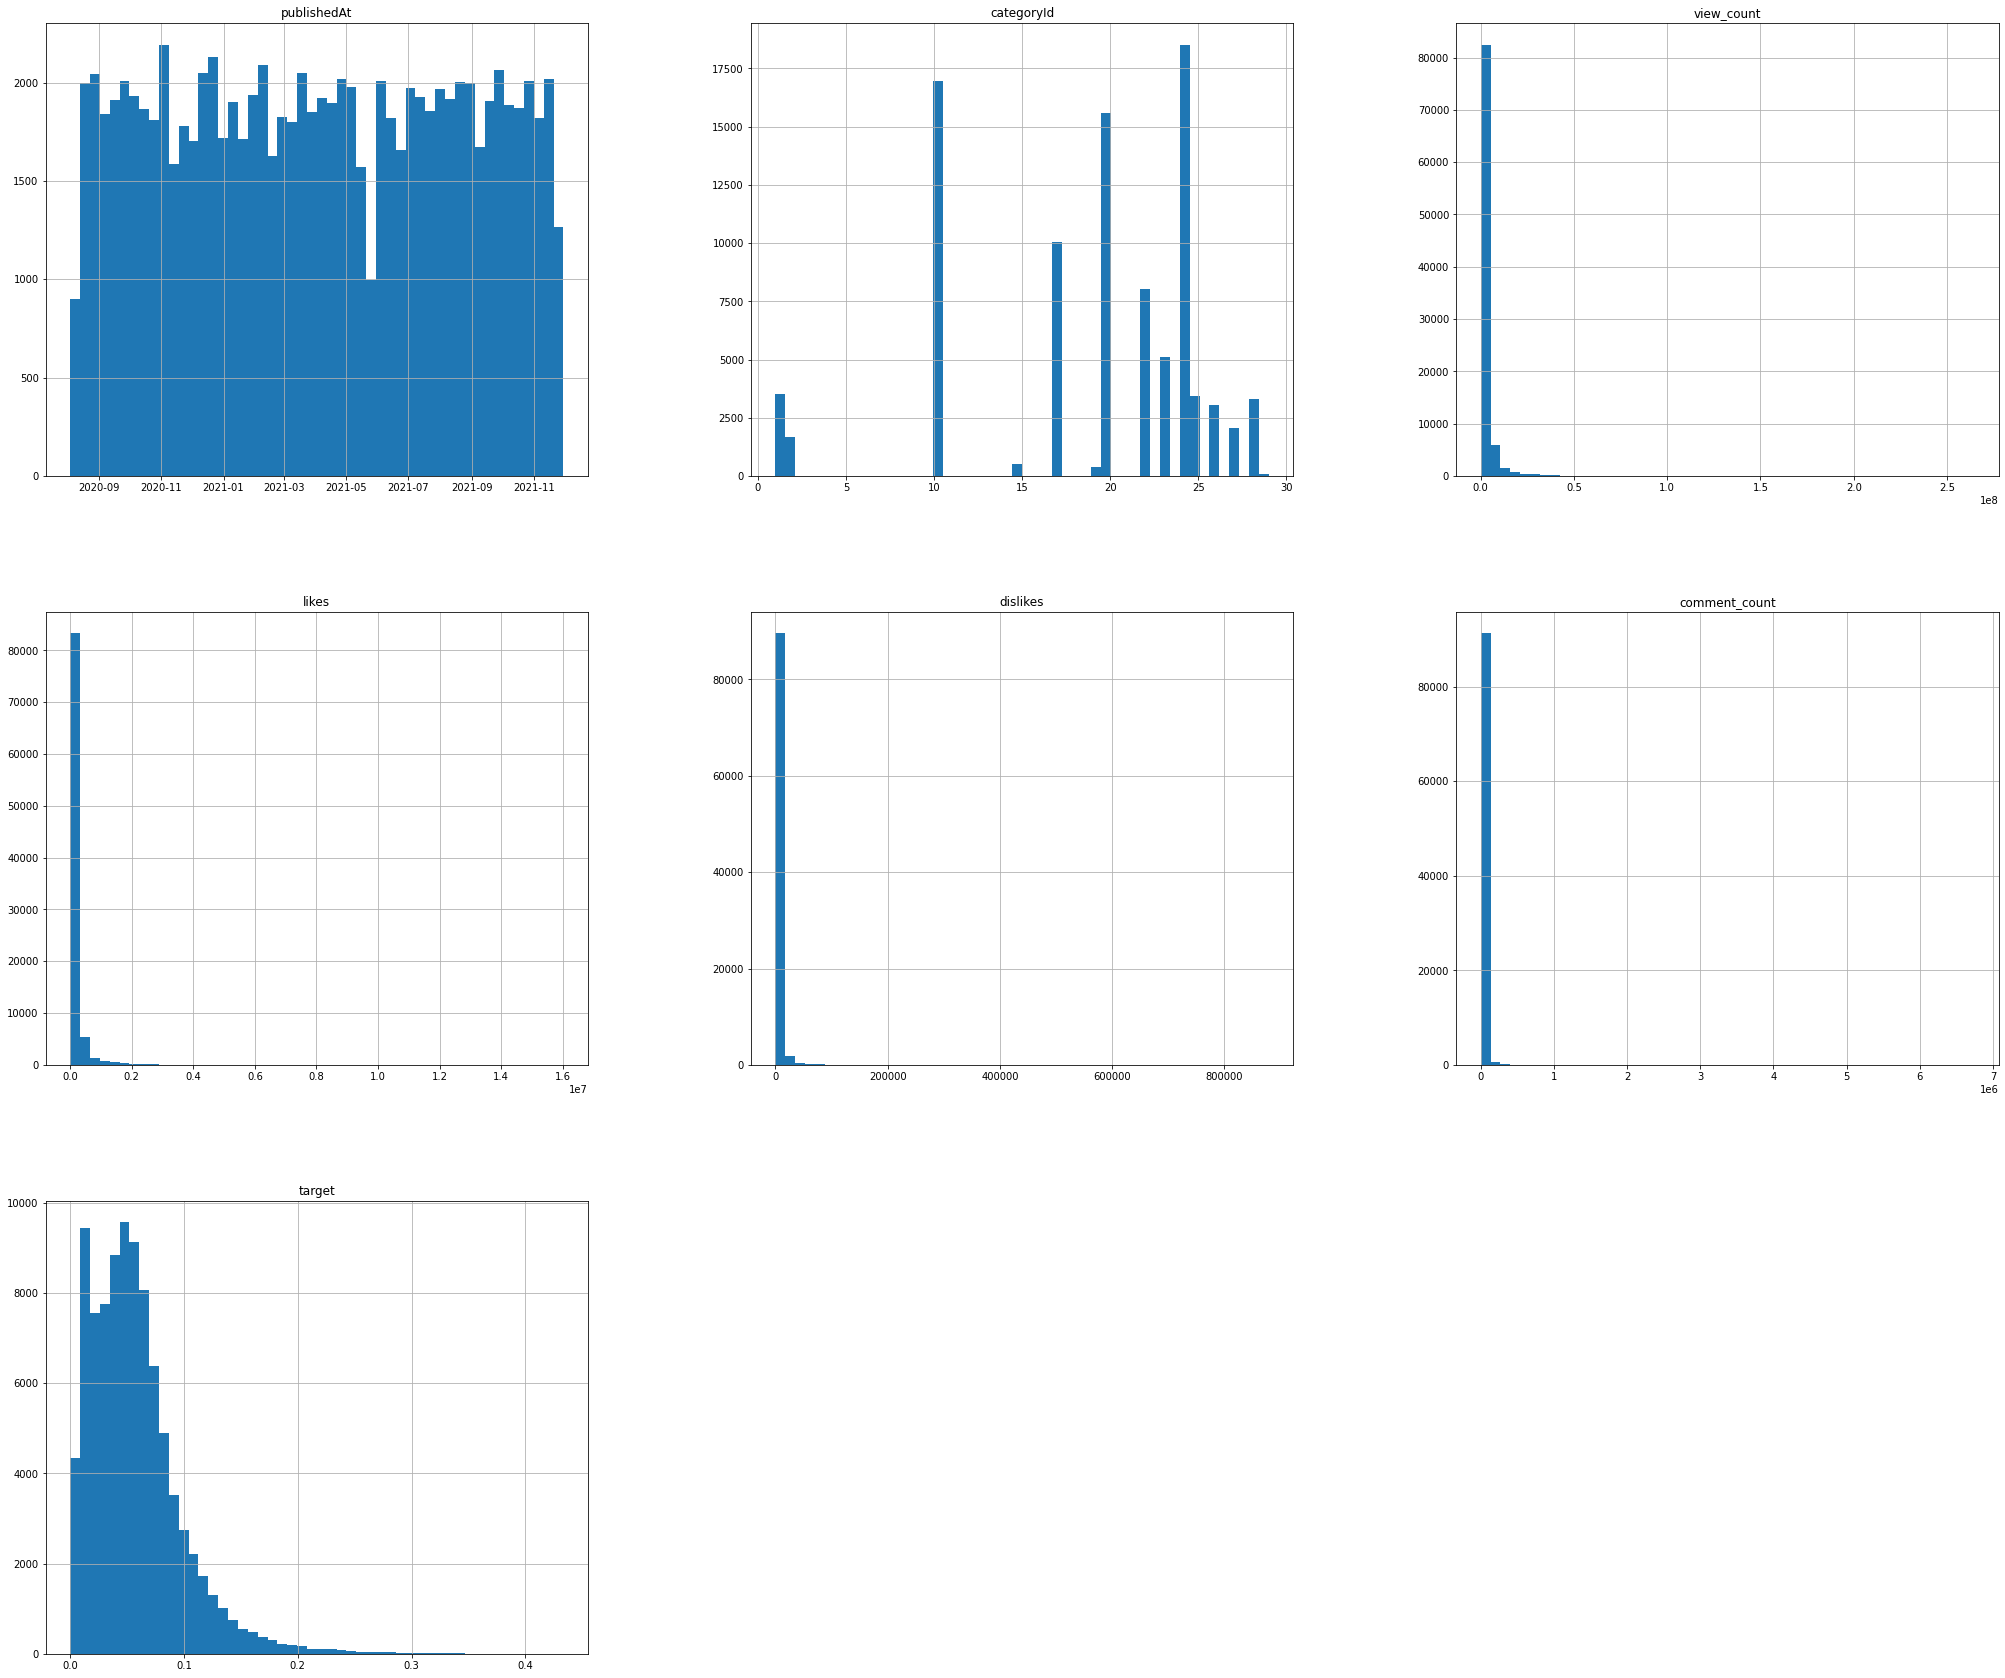

In [10]:
train_set.hist(bins=50, figsize=(35,30))

In [11]:
#Look for correlations
corr_matrix = train_set.corr()
corr_matrix["target"].sort_values(ascending=False)

target               1.000000
likes                0.203877
comment_count        0.081980
has_thumbnail        0.019487
dislikes             0.004226
view_count          -0.021704
comments_disabled   -0.089399
categoryId          -0.096996
ratings_disabled    -0.098274
Name: target, dtype: float64

In [12]:
drop_cols=['publishedAt', 'trending_date']
train=train_set.drop(drop_cols,axis=1)
train.columns

Index(['video_id', 'title', 'channelId', 'channelTitle', 'categoryId', 'tags',
       'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link',
       'comments_disabled', 'ratings_disabled', 'description', 'id',
       'duration_seconds', 'has_thumbnail', 'target'],
      dtype='object')

In [13]:
#Code by Diego Risco https://www.kaggle.com/ggxgboostgg/wids-2022-shap-values-validation/notebook

cat_var = train.select_dtypes(include=[object]).columns.to_list()
cat_var.append('categoryId')
x_train = train.drop(['target'], axis = 1)
y_train = train.copy()['target']

In [14]:
#Code by Diego Risco https://www.kaggle.com/ggxgboostgg/wids-2022-shap-values-validation/notebook

addBinary_imputer = AddMissingIndicator()
rare_encoder = RareLabelEncoder(tol=0.02, n_categories=2, variables=cat_var,
                           replace_with=-999, ignore_format = True)
mean_encoder = MeanEncoder(variables=cat_var, ignore_format = True)

pipe = Pipeline([('indicator', addBinary_imputer),
                 ('RareLabelEncoder1', rare_encoder),
                 ('MeanEncoder', mean_encoder)])

In [15]:
lgbm_model = LGBMRegressor(random_state = random_state)

In [16]:
x_train_processed = pipe.fit_transform(x_train, y_train)
lgbm_model.fit(x_train_processed,y_train)

LGBMRegressor(random_state=123)

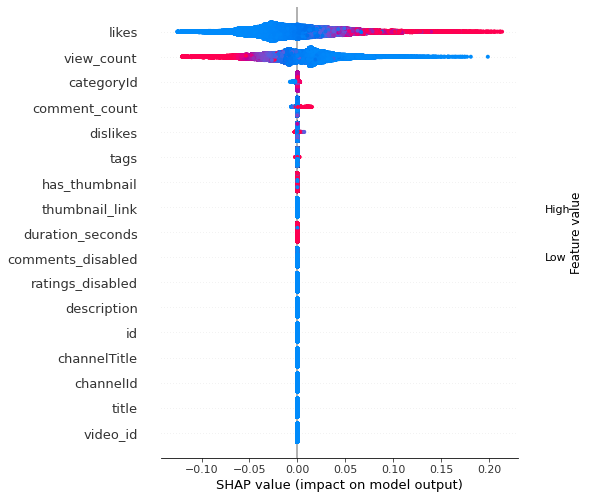

In [17]:
#Code by Diego Risco https://www.kaggle.com/ggxgboostgg/wids-2022-shap-values-validation/notebook

shap_values = shap.TreeExplainer(lgbm_model).shap_values(x_train_processed)
shap.summary_plot(shap_values, x_train_processed)